# PCA

### 주성분 분석 (Principal component Analysis, PCA)
PCA는 데이터에 가장 가까운 초평면(hyperplane)을 정의한 후, 데이터를 평면에 투영시키는 차원 축소 알고리즘이다.

## 분산 보존

저차원의 초평면에 훈련세트를 투영할 때에는 정보가 가장 적게 손실되게 하기 위해서 분산이 최대로 보존되는 축을 선택해야 한다. 이를 위해서는 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화 하는 축을 찾으면 된다.

아래 그림에서는 실선이 가장 분산이 크므로, 실선에 투영하는 것이 가장 합리적이다.

<img src="./images/selecting_subspace.png" alt="selecting_subspace" width="70%">

## 주성분 (Principal Component, PC)

PCA는 훈련세트에서 분산이 최대인 축을 계속해서 찾아 나가는데, 이렇게 찾아진 각 축들을 찾아진 순서대로 i번째 주성분(PC)이라고 부른다. 예를 들어, 앞의 그림에서 1번째 PC는 벡터 $c_1$이고, 2번째 PC는 벡터 $c_2$이다.

PCA를 분해하는 과정에는 행렬의 특잇값 분해(SVD)가 사용된다.

또한, PCA가 반환하는 PC들은 같은 축에서 다른 방향을 가리킬 수 있으며, PCA는 데이터 셋의 평균이 0이라고 가정하므로, 사이킷런이 아닌 다른 라이브러리를 사용하거나 직접 구현한다면, 먼저 데이터를 원점에 맞추어 주어야 한다.(사이킷런의 `PCA`는 이 작업을 처리해줌)

## d차원으로 투영하기

주성분을 모두 추출하고, 처음 d개의 주성분으로 정의한 초평면에 투영하면, 데이터셋의 차원을 d차원으로 축소시킬 수 있다.

예를 들어, 앞서 살펴본 아래의 3D 데이터셋에서는,
<img src="./images/projection_3d.png" alt="projection_3d"  width="60%">

다음과 같이 분산이 가장 큰 첫 2개의 주성분으로 구성된 2D 평면에 투영된 것을 알 수 있다.

<img src="./images/projection_2d.png" alt="projection_2d"  width="50%">

## 사이킷런 사용하기

사이킷런의 PCA 모델은 내부적으로 SVD 분해 방법을 사용해 동작한다. 다음은 PCA를 사용해 데이터셋의 차원을 2차원으로 줄이는 코드이다.

In [1]:
# 3D 데이터셋 생성

import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [2]:
# 사이킷런을 이용한 3D -> 2D

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

## 설명된 분산의 비율

설명된 분산의 비율(explained variance ratio)은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다.

앞서 학습시킨 PCA변환기의 `explained_variance_ratio_` 변수를 통해 확인할 수 있다.

In [3]:
print(pca.explained_variance_ratio_)

[0.84248607 0.14631839]


위 결과는 데이터셋 분산의 84.2%가 첫번째 PC에 있고, 14.6%가 두번째 PC에 있다는 것이다.

## 적절한 차원 수 선택하기

축소할 차원의 수를 결정하는 방법 중 하나는 충분한 분산(예를 들어 95%)이 될 때까지의 차원 수를 선택하는 것이다.

다음은 MNIST 데이터셋에서 PCA를 계산한 후, 분산이 95%이상이 되는데 필요한 차원의 수를 계산하는 코드이다.

In [4]:
# MNIST 데이터셋 불러오기

import os

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset_root = os.path.join(os.getcwd(), 'datasets')
if not os.path.isdir(dataset_root):
    os.mkdir(dataset_root)
    
mnist = fetch_openml('mnist_784', version=1, data_home=dataset_root)
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)+1

print(d)

154


그리고 다시 `n_components=d`로 설정해 PCA를 실행하면 된다.

In [6]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)

위의 과정을 `n_components`에 분산의 비율을 바로 지정해 수행하는 방법도 있다.(훨씬 간단함)

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

적절한 차원의 수를 결정하는 또 다른 방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것이다. 이는 `cumsum`을 그래프로 그리는 것을 의미한다.

이 방법을 사용하면 다음과 같이 변곡점을 찾을 수 있으며, 이를 통해 154가 아닌 100으로 하여도 큰 차이가 없다는 내용을 알 수 있다.

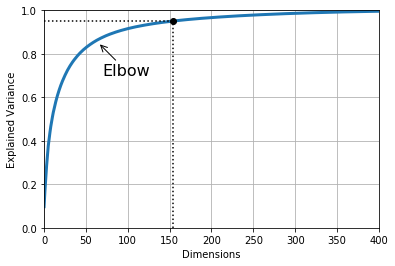

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## 압축을 위한 PCA

차원을 축소하면 훈련 세트의 크기가 줄어든다. 앞에서 수행한 MNIST의 경우, 원본 크기의 20% 미만이 된다. 이와 같이 PCA는 압축에도 사용할 수 있다.


### 재구성 오차(reconstruction error)
압축한 MNIST 데이터셋에 PCA 투영의 변환을 반대로 수행하면, 원래의 차원으로 되돌릴 수도 있지만, 완전한 원본 데이터셋을 얻을 수는 없다.

이때, 원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리를 재구성 오차(reconstruction error)라고 한다.

MNIST를 예로 들면, 154차원으로 압축 후, 다시 784차원으로 복원한 것과 원래의 데이터셋(784차원) 사이의 평균 제곱 거리이다.

다음은 사이킷런의 `inverse_transform()`을 사용해 앞서 압축한 MNIST 데이터셋을 원래의 차원으로 복원하는 코드이다.

In [9]:
X_recovered = pca.inverse_transform(X_reduced)

## 점진적 PCA

PCA의 단점은 SVD를 수행하기 위해서는 전체 학습 데이터셋을 메모리에 올려야 한다는 것이다. 이러한 단점을 보완하기 위해 Incremental PCA(IPCA) 알고리즘이 개발되었다. 

IPCA는 학습 데이터셋을 미니배치로 나눈 뒤 IPCA 알고리즘에 하나씩 주입한다. 이는 학습 데이터셋이 클때 유용하다.

아래 코드는 사이킷런의 `IncrementalPCA`를 사용해 MNIST 데이터셋을 100개의 미니 배치로 나누고, 앞의 예제와 같이 154개의 차원으로 줄이는 코드이다.

In [10]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

다른 방법으로는 numpy의 `memmap` 클래스를 사용해 필요할 때 하드디스크에 저장된 데이터를 메모리에 적재하며 `IncrementalPCA`를 사용하는 방법도 있다.